In [145]:
import os, findspark

#  Spark 4.0.1
os.environ["SPARK_HOME"] = "/opt/spark-4.0.1-bin-hadoop3"
os.environ["PATH"] = os.path.join(os.environ["SPARK_HOME"], "bin") + ":" + os.environ["PATH"]


findspark.init("/opt/spark-4.0.1-bin-hadoop3")

# create Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

In [146]:
# Load CSV file into Spark DataFrame

df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .option("multiLine", "true")
        .option("escape", "\"")
        .csv("data/lightcast_job_postings.csv")
)

In [147]:
df.count()

72498

In [148]:
df.show(5)
len(df.columns)

+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

131

In [149]:
df.printSchema() 

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

# 4 Data Cleaning & Preprocessing
# 4.1 Drop Unnecessary Columns

4.1.1 Which columns are irrelevant or redundant?

4.1.2 Why are we removing multiple versions of NAICS/SOC codes?

4.1.3 How will this improve analysis?

The CITY column was removed because it contains encoded strings instead of actual city names.

# 4.2 Dropping Unnecessary Columns
We remove redundant NAICS/SOC codes and tracking data to simplify our dataset. Keeping only the latest NAICS_2022_6 and SOC_2021_4 ensures that our analysis reflects current industry and occupational classifications.

In [150]:
columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_4", "SOC_5",
    "NAICS_2022_2", "NAICS_2022_3","NAICS_2022_4","NAICS_2022_5",
    "NAICS_2022_2_NAME","NAICS_2022_3_NAME","NAICS_2022_4_NAME","NAICS_2022_5_NAME",
    "SOC_5_NAME","SOC_4_NAME","SOC_3_NAME","SOC_2_NAME",
    "NAICS2_NAME","NAICS3_NAME","NAICS4_NAME","NAICS5_NAME",
    "LAST_UPDATED_DATE","EXPIRED","DURATION",    # date variables are not related to our topic 
    "MODELED_EXPIRED","MODELED_DURATION","MODELED_EXPIRED",
    "COMPANY", "TITLE", "SKILLS",                  # remove numerical COMPANY
    "MAX_EDULEVELS","MAX_EDULEVELS_NAME",
    "EMPLOYMENT_TYPE","REMOTE_TYPE", "EMPLOYMENT_TYPE",     # remove numerical EMPLOYMENT_TYPE, REMOTE_TYPE, keeping the text version
    "LOCATION", "CITY","COUNTY","MSA","STATE", 
    "MSA_NAME", "COUNTY_NAME_OUTGOING", "COUNTY_NAME_INCOMING", "MSA_NAME_OUTGOING", "MSA_NAME_INCOMING",   
    "COUNTY_OUTGOING","COUNTY_INCOMING", "MSA_OUTGOING", "MSA_INCOMING",         # LOCATION contains latitude and longitude coordinates, CITY ontains encoded strings instead of actual city names 
    "EDUCATION_LEVELS", "MIN_EDULEVELS",  # encoded strings instead of actual EDUCATION_LEVELS, we keep EDUCATION_LEVELS_NAME. MIN_EDULEVELS contains number 
    "SPECIALIZED_SKILLS", "CERTIFICATIONS", "COMMON_SKILLS", "SOFTWARE_SKILLS",    # encoded strings
    "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME", "SOC_2021_5", "SOC_2021_5_NAME",
    "LOT_CAREER_AREA", "LOT_OCCUPATION", "LOT_SPECIALIZED_OCCUPATION", "LOT_OCCUPATION_GROUP","LOT_V6_SPECIALIZED_OCCUPATION", "LOT_V6_CAREER_AREA", "LOT_V6_OCCUPATION_GROUP",  
    "ACTIVE_SOURCES_INFO", "MAX_YEARS_EXPERIENCE", "LIGHTCAST_SECTORS", "LIGHTCAST_SECTORS_NAME", "ORIGINAL_PAY_PERIOD",   # missing values >50%
    "SOURCE_TYPES", "SOURCES", "BODY", 
    "COMPANY_NAME", "TITLE_NAME",  #keep  COMPANY_RAW and TITLE_CLEAN (simplified version)
    "ONET", "ONET_2019","CIP6", "CIP4", "CIP2",       # numerical 
    "CIP6_NAME","CIP4_NAME","CIP2_NAME",     # remove zipcode-related variables, we keep location name from state to county
    
] 

df = df.drop(*columns_to_drop)

In [151]:
df.show(5)

len(df.columns)

+--------+--------------------+-----------+-------------------+---------------------+-------------------+--------------------+--------------------+-------------+------+----------------+---------+-----------+-------------+--------------+----------+--------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+---------------+--------------------+--------------------+-------------------------------+-------------------------+----------------------------------+-----------------+----------------------+----------------------------+-----------------------+------------+--------------------+
|  POSTED|           TITLE_RAW|COMPANY_RAW|COMPANY_IS_STAFFING|EDUCATION_LEVELS_NAME| MIN_EDULEVELS_NAME|EMPLOYMENT_TYPE_NAME|MIN_YEARS_EXPERIENCE|IS_INTERNSHIP|SALARY|REMOTE_TYPE_NAME|SALARY_TO|SALARY_FROM|    CITY_NAME|   COUNTY_NAME|STATE_NAME|         NAICS6_NAME|  

38

In [152]:
from pyspark.sql import functions as F

total_rows = df.count()

exprs = [
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]

missing_row = df.agg(*exprs).collect()[0].asDict()

missing_stats = [(col, missing_row[col], missing_row[col] / total_rows)
                 for col in df.columns]

missing_df = spark.createDataFrame(
    missing_stats,
    ["column", "missing_count", "missing_ratio"]
)

missing_df.orderBy("missing_ratio", ascending=False).show(60)

+--------------------+-------------+--------------------+
|              column|missing_count|       missing_ratio|
+--------------------+-------------+--------------------+
|              SALARY|        41690|  0.5750503462164474|
|           SALARY_TO|        40100|   0.553118706722944|
|         SALARY_FROM|        40100|   0.553118706722944|
|MIN_YEARS_EXPERIENCE|        23146| 0.31926397969599163|
|         COMPANY_RAW|          541|0.007462274821374383|
|         TITLE_CLEAN|          140|0.001931087754144942|
|           TITLE_RAW|          104|0.001434522331650...|
|SPECIALIZED_SKILL...|           44|6.069132941598389E-4|
| COMPANY_IS_STAFFING|           44|6.069132941598389E-4|
| CERTIFICATIONS_NAME|           44|6.069132941598389E-4|
|EDUCATION_LEVELS_...|           44|6.069132941598389E-4|
|  COMMON_SKILLS_NAME|           44|6.069132941598389E-4|
|  MIN_EDULEVELS_NAME|           44|6.069132941598389E-4|
|SOFTWARE_SKILLS_NAME|           44|6.069132941598389E-4|
|EMPLOYMENT_TY

# 4.3 Handle Missing Values
How should missing values be handled?

# 4.4 Handling Missing Values

- Numerical fields (e.g., Salary) are filled with the median.

- Categorical fields (e.g., Industry) are replaced with "Unknown".

- Columns with >50% missing values are dropped. (We already finished that by dropping un-relevant conlumns', but salary varaibles are super important so we still keep it and we will see whatever we can do later.)

In [153]:
# Fill numerical missing values
median_experience = df.approxQuantile("MIN_YEARS_EXPERIENCE", [0.5], 0.01)[0]
df = df.fillna({"MIN_YEARS_EXPERIENCE": median_experience})

In [154]:
# Fill categorical missing values
df = df.fillna({"NAICS_2022_6_NAME": "Unknown"})

In [155]:
from pyspark.sql import functions as F

total_rows = df.count()

# Compute missing count for each column
exprs = [
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]

missing_row = df.agg(*exprs).collect()[0].asDict()

# Convert into list of (column, missing_count)
missing_stats = [(col, missing_row[col]) for col in df.columns]


missing_df = spark.createDataFrame(
    missing_stats,
    ["column", "missing_count"]
)


missing_df.orderBy("missing_count", ascending=False).show(60)

+--------------------+-------------+
|              column|missing_count|
+--------------------+-------------+
|              SALARY|        41690|
|           SALARY_TO|        40100|
|         SALARY_FROM|        40100|
|         COMPANY_RAW|          541|
|         TITLE_CLEAN|          140|
|           TITLE_RAW|          104|
|SPECIALIZED_SKILL...|           44|
| COMPANY_IS_STAFFING|           44|
| CERTIFICATIONS_NAME|           44|
|EDUCATION_LEVELS_...|           44|
|  COMMON_SKILLS_NAME|           44|
|  MIN_EDULEVELS_NAME|           44|
|SOFTWARE_SKILLS_NAME|           44|
|EMPLOYMENT_TYPE_NAME|           44|
|           ONET_NAME|           44|
|       IS_INTERNSHIP|           44|
|      ONET_2019_NAME|           44|
|    REMOTE_TYPE_NAME|           44|
|          SOC_2021_4|           44|
|           CITY_NAME|           44|
|     SOC_2021_4_NAME|           44|
|         COUNTY_NAME|           44|
|LOT_CAREER_AREA_NAME|           44|
|          STATE_NAME|           44|
|

# 5 Exploratory Data Analysis (EDA)


📌 In your Quarto report, explain:
- ✅ Why these visualizations were chosen.
- ✅ Key insights from each graph.

In [156]:
from pyspark.sql import functions as F

# Remove rows with missing SALARY
df = df.filter(F.col("SALARY").isNotNull())

# Remove duplicates based on key job-identifying fields
df = df.dropDuplicates(
    subset=[
        "CITY_NAME",
        "COUNTY_NAME",
        "STATE_NAME",
        "TITLE_CLEAN",
        "COMPANY_RAW",
        "POSTED"
    ]
)


print("Rows after cleaning:", df.count())

Rows after cleaning: 30613


First, we removed all records with missing salary values, eliminating a total of 41,690 rows.

Next, we addressed duplicate job postings. We used six fields—city (CITY_NAME), county (COUNTY_NAME), state (STATE_NAME), job title (TITLE_CLEAN), company name (COMPANY_RAW), and posting date (POSTED) as a composite identifier for uniqueness. When all six fields are identical, the records represent the same job posting.

After applying these two filtering steps, 30,613 rows remain in the dataset. Compared with the original 72,498 rows, this represents only 42.23% of the initial data. 

# 5.1.1 Choropleth Map Salary Distribution by State

In [157]:
from pyspark.sql import functions as F

# compute average state salary
state_salary = (
    df.groupBy("STATE_NAME")
      .agg(F.avg("SALARY").alias("AVG_SALARY"))
      .orderBy("AVG_SALARY", ascending=False)
)

state_salary.show(55)


+--------------------+------------------+
|          STATE_NAME|        AVG_SALARY|
+--------------------+------------------+
|         Connecticut|128023.34320987655|
|             Vermont|126231.86138613861|
|          New Jersey|125863.67491166078|
|          Washington|124996.29621621621|
|            Arkansas|124562.04406779661|
|            Virginia|124061.19700374531|
|          California|123963.91967668603|
|            Illinois|122737.81581027668|
|       Massachusetts|122488.78580990629|
|            Delaware|122415.08496732026|
|Washington, D.C. ...|121674.43347639484|
|             Montana|          120861.0|
|            Maryland|119381.37370242215|
|            Nebraska|119225.37209302325|
|            Michigan|118822.82258064517|
|      North Carolina|118158.80922431865|
|            Oklahoma|117910.32225913621|
|               Texas|117696.12257040857|
|                Iowa|117501.89523809524|
|            New York|116600.96262626263|
|             Georgia| 115984.1817

In [158]:
pdf = state_salary.toPandas()

In [159]:
import us

pdf["STATE_ABBR"] = pdf["STATE_NAME"].apply(
    lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
)

In [162]:
import plotly.express as px
import plotly.io as pio


pio.renderers.default = "browser"


fig = px.choropleth(
    pdf,
    locations="STATE_ABBR",
    locationmode="USA-states",
    color="AVG_SALARY",
    color_continuous_scale="Plasma",
    scope="usa",
    labels={"AVG_SALARY": "Average Salary"},
    title="Average Salary by State"
)

fig.show()

In [163]:
fig.write_html("figure/average_salary_map.html")

# 5.1.2 Remote / Hybrid / On-site Employment Distribution by State

In [164]:
from pyspark.sql.functions import when, col, trim, upper

# Clean and rename EMPLOYMENT_TYPE_NAME
df = df.withColumn(
    "EMPLOYMENT_TYPE_CLEANED",
    when(upper(trim(col("EMPLOYMENT_TYPE_NAME"))).like("%PART-TIME / FULL-TIME%"), "Flexible")
    .when(upper(trim(col("EMPLOYMENT_TYPE_NAME"))).like("%FULL-TIME%"), "Full-time")
    .when(upper(trim(col("EMPLOYMENT_TYPE_NAME"))).like("%PART-TIME%"), "Part-time")
    .otherwise(None)
)

df.select("EMPLOYMENT_TYPE_NAME", "EMPLOYMENT_TYPE_CLEANED").distinct().show(truncate=False)

+------------------------+-----------------------+
|EMPLOYMENT_TYPE_NAME    |EMPLOYMENT_TYPE_CLEANED|
+------------------------+-----------------------+
|Part-time (â‰¤ 32 hours)|Part-time              |
|Full-time (> 32 hours)  |Full-time              |
|Part-time / full-time   |Flexible               |
+------------------------+-----------------------+



In [165]:
from pyspark.sql import functions as F

# Pivot Table（Full-time / Part-time / Flexible）distribution by State
employment_pivot = (
    df.groupBy("STATE_NAME")
      .pivot("EMPLOYMENT_TYPE_CLEANED")   
      .count()
)

# job posting by state
job_posting_count = (
    df.groupBy("STATE_NAME")
      .count()
      .withColumnRenamed("count", "job_posting")
)

# pivot table + job posting，in descending order by total job postings
employment_final = (
    employment_pivot
    .join(job_posting_count, on="STATE_NAME", how="left")
    .orderBy(F.desc("job_posting"))
)

employment_final.show(60, truncate=False)


+---------------------------------------+--------+---------+---------+-----------+
|STATE_NAME                             |Flexible|Full-time|Part-time|job_posting|
+---------------------------------------+--------+---------+---------+-----------+
|California                             |84      |3741     |134      |3959       |
|Texas                                  |23      |2428     |70       |2521       |
|New York                               |27      |1879     |74       |1980       |
|Florida                                |26      |1436     |30       |1492       |
|Virginia                               |68      |1230     |37       |1335       |
|Illinois                               |3       |1233     |29       |1265       |
|North Carolina                         |25      |877      |52       |954        |
|Colorado                               |24      |868      |45       |937        |
|Ohio                                   |10      |877      |39       |926        |
|Was

In [166]:
import plotly.graph_objects as go

# convert Spark DF to pandas
pdf = employment_final.toPandas()

# Sort by total job posting
pdf = pdf.sort_values("job_posting", ascending=False)

# Colors
colors = {
    "Full-time": "#C97B63",   # Morandi Red
    "Part-time": "#7A9E9F",  # Morandi Blue
    "Flexible":  "#D8C690"   # Morandi Yellow
}

# Create figure
fig = go.Figure()

fig.add_trace(go.Bar(
    x=pdf["STATE_NAME"],
    y=pdf["Full-time"],
    name="Full-time",
    marker_color=colors["Full-time"]
))

fig.add_trace(go.Bar(
    x=pdf["STATE_NAME"],
    y=pdf["Part-time"],
    name="Part-time",
    marker_color=colors["Part-time"]
))

fig.add_trace(go.Bar(
    x=pdf["STATE_NAME"],
    y=pdf["Flexible"],
    name="Flexible",
    marker_color=colors["Flexible"]
))

fig.update_layout(
    barmode='stack',
    title={
        'text': "Full-time / Part-time / Flexible Employment Distribution by State",
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 22, 'family': 'Arial', 'color': 'black'}
    },
    xaxis_title="State",
    yaxis_title="Number of Job Postings",
    xaxis_tickangle=45,
    legend_title="Employment Type",
    width=1400,
    height=700
)


fig.show()

In [167]:
fig.write_html("figure/employment_distribution_by_state.html")

# 5.1.3 Top Job Titles × Job Postings × Average Salary

In [168]:
from pyspark.sql import functions as F

# Top 15 job titles
top15_titles = (
    df.groupBy("TITLE_CLEAN")
      .agg(
          F.count("*").alias("job_postings"),
          F.avg("SALARY").alias("avg_salary")
      )
      .orderBy(F.desc("job_postings"))   # ordering by jobpostings
      .limit(15)                         
)

# ordering by average salary
top15_sorted = (
    top15_titles
      .orderBy(F.desc("avg_salary"))    
)

top15_sorted.show(15, truncate=False)


+---------------------------------------------------+------------+------------------+
|TITLE_CLEAN                                        |job_postings|avg_salary        |
+---------------------------------------------------+------------+------------------+
|data engineer analytics                            |135         |223930.24444444446|
|oracle hcm cloud manager                           |87          |184262.06896551725|
|enterprise architect                               |296         |157046.35135135136|
|oracle hcm cloud implementation lead core hr module|134         |152712.68656716417|
|solution architect                                 |105         |140712.9619047619 |
|data modeler                                       |83          |129952.15662650602|
|data analytics engineer                            |97          |124616.31958762887|
|sr data analyst                                    |105         |123114.13333333333|
|senior data analyst                                |3

In [169]:
top15_pd = top15_sorted.toPandas()

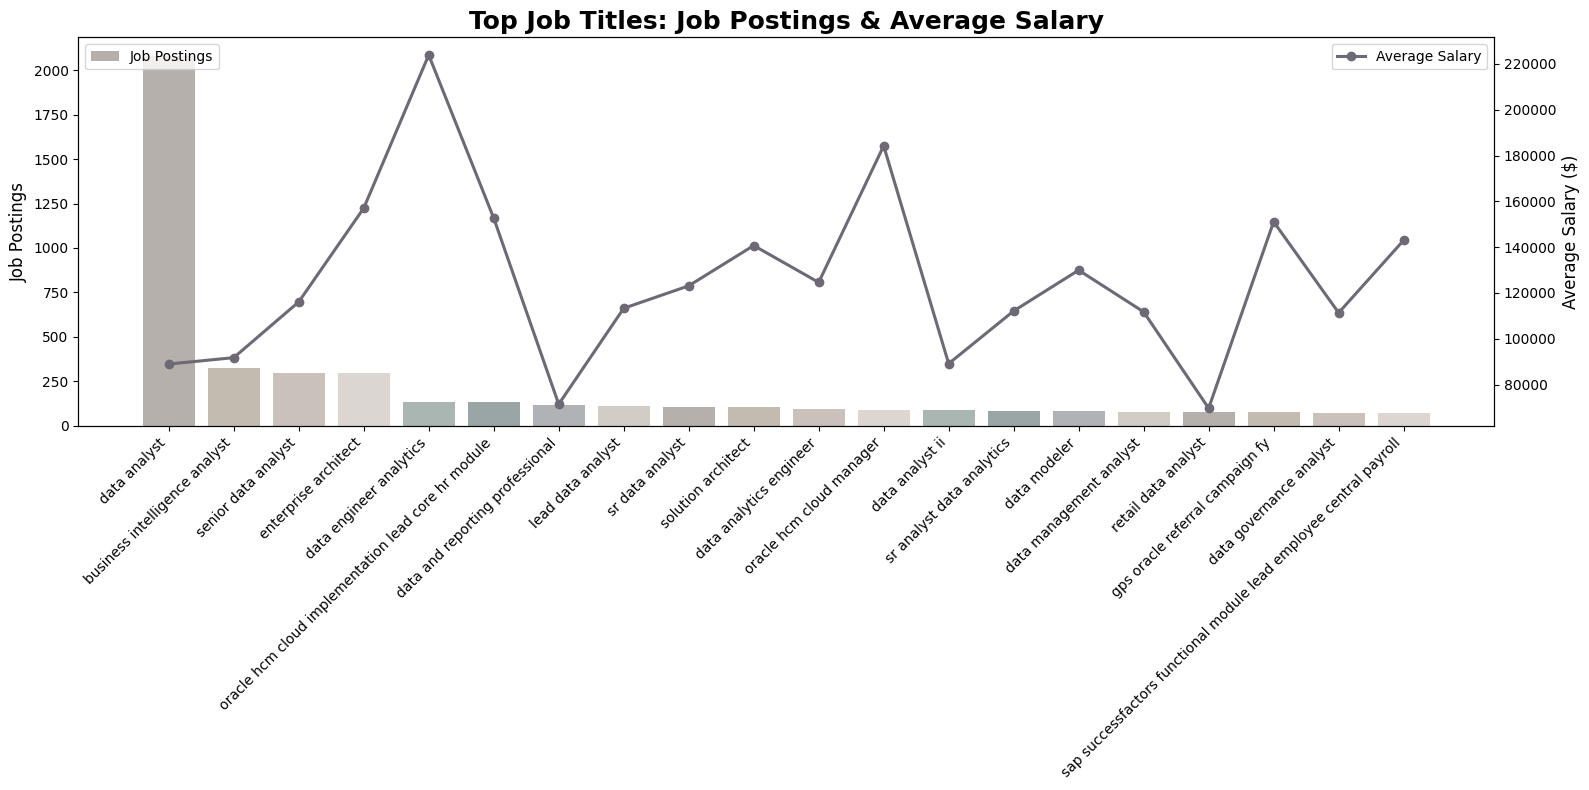

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df_plot = top20_pd.sort_values("job_postings", ascending=False)


fig, ax = plt.subplots(figsize=(16, 8))


morandi_palette = [
    "#A8A39D", "#B7AFA3", "#C1B7B0", "#D6CFCB",
    "#9AA9A4", "#889696", "#A3A5A8", "#C9C5BB"
]
colors = [morandi_palette[i % len(morandi_palette)] for i in range(len(df_plot))]

# Bar Chart 
ax.bar(df_plot["TITLE_CLEAN"], df_plot["job_postings"],
       color=colors, alpha=0.85, label="Job Postings")

# Line Chart 
ax2 = ax.twinx()
ax2.plot(df_plot["TITLE_CLEAN"], df_plot["avg_salary"],
         color="#6D6A75", marker="o", linewidth=2.2, label="Average Salary")


plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)


ax.set_title("Top Job Titles: Job Postings & Average Salary", fontsize=18, fontweight="bold")
ax.set_ylabel("Job Postings", fontsize=12)
ax2.set_ylabel("Average Salary ($)", fontsize=12)


ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [180]:
plt.savefig("figure/top15_jobtitles_dualaxis.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>